In [18]:
# Importing libraries 
import pandas as pd
import os
from  statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

In [19]:
# Setting the relative path
def import_cvs_as_dataframe(stock):
    ''' This function takes the stock name of the dataset (as a string) and import it as a clean data frame. '''
    
    file_path = os.path.join('../data', stock+'.csv')
    df = (pd.read_csv(file_path)
          .assign(Date = lambda stock: pd.to_datetime(stock['Date']))
          .dropna()
          .set_index('Date')
         )
    return df

In [20]:
def plot_close_price_on_one_plot(df1, df2, df3, header1, header2, header3): 
    '''This function takes three data frames with headers, and return a plot to visualize and compare the daily close price for each stock on the same plot'''
    plt.figure(figsize=(10, 6))
    dfx = [df1, df2, df3]
    
    headerx = [header1, header2, header3]
    
    for d, h in zip(dfx, headerx):
        d['Close'].loc['2019-01-02':'2022-02-25'].plot(label= h)

    plt.xlabel('Date')
    plt.ylabel('USD')
    plt.title('Daily Closing Prices')
    plt.legend(loc = 'upper left')
    
    return plt.show()

In [21]:
def plot_compares_open_and_close_price_on_one_plot(df1, df2, df3, header1, header2, header3): 
    '''This function takes three data frames with headers, and return subplots to visualize and compare the daily close and open price for each stock individually'''

    fig, axes = plt.subplots(nrows=3, ncols=1)
    fig.set_figheight(26)
    fig.set_figwidth(10)
    
    dfx = [df1, df2, df3]
    headerx = [header1, header2, header3]
    i = 0
    for d, h in zip(dfx, headerx):
        
        d['Open'].plot(ax=axes[i])
        d['Close'].plot(ax=axes[i]).legend(loc = 'lower right')
        axes[i].set_title(h + ' Daily Open and Close Prices')
        axes[i].set_xlabel('Date')
        axes[i].set_ylabel('USD')
        i = i + 1
    
    return plt.show()

In [22]:
def plot_volume_traded(df1, df2, df3, header1, header2, header3):
    '''This function takes three data frames with headers, and return subplots to visualize and compare the daily volume traded for each stock individually'''

    fig, axes = plt.subplots(nrows=3, ncols=1)
    fig.set_figheight(26)
    fig.set_figwidth(10)
    
    dfx = [df1, df2, df3]
    headerx = [header1, header2, header3]
    i = 0
    for d, h in zip(dfx, headerx):

        d['Volume'].plot(ax=axes[i])
        axes[i].set_title(h + ' Daily Volume Traded')
        axes[i].set_xlabel('Date')
        axes[i].set_ylabel('Shares')
        i = i + 1
    
    return plt.show()

In [23]:
def plot_Log_Return(df1, df2, df3, header1, header2, header3):
    '''This function takes three data frames with headers, and return histogram subplots to visualize and compare the daily Log return for each stock individually'''

    dfx = [df1, df2, df3]
    for d in dfx:
        d['LogReturn'] = np.log(d['Close']).shift(-1) - np.log(d['Close'])
        d = d.dropna()

    fig, axes = plt.subplots(nrows=3, ncols=1)
    fig.set_figheight(26)
    fig.set_figwidth(10)
    
    headerx = [header1, header2, header3]
    i = 0
    for d, h in zip(dfx, headerx):
        d['LogReturn'].hist(bins = 50, ax=axes[i])
        axes[i].set_title(h + ' Daily Return')
        axes[i].set_xlabel('Log Return')
        axes[i].set_ylabel('Frequency')
        i = i + 1

    return plt.show()

In [24]:
def Calculating_value_at_risk(df1, df2, df3, header1, header2, header3):
    '''This function takes three data frames with headers, and return the value at risk (VAR) for 5%, 95%, 25%, and 75% quantiles'''
    dfx = [df1, df2, df3]
    mu = []
    sigma = []
    for d in dfx:
        m = d['LogReturn'].mean()
        s = d['LogReturn'].std(ddof=1)
        mu.append(m)
        sigma.append(s)
        
    headerx = [header1, header2, header3]
    
    for m, s, h in zip(mu, sigma, headerx):
            print('VAR for '+ h)
            print('5% quantile ', norm.ppf(0.05, m, s))
            print('95% quantile ', norm.ppf(0.95, m, s))
            print('25% quantile ', norm.ppf(0.25, m, s))
            print('75% quantile ', norm.ppf(0.75, m, s))

In [25]:
def adding_moving_averages(df):
    ''' This function takes a data frame of the stock and returns a new data frame with 3 columns 
        [Closing price, and 2 Moving Averages (fast & slow signals)] that is ready for plotting the stock signals. '''
    
    df_ma = df['Close'].to_frame()
    df_ma['MA7'] = df_ma['Close'].rolling(7).mean()
    df_ma['MA40'] = df_ma['Close'].rolling(40).mean()
    df_ma = df_ma.dropna()
    
    return df_ma

In [26]:
def plot_fast_slow_signals(df, header):
    ''' This function takes a data frame of a certain stock and a name of the plot title as a string, 
        and returns a plot to visualize the signals movement of the stock. '''
    
    df_ma = adding_moving_averages(df)
    plt.figure(figsize=(10, 8))
    df_ma['MA7'].loc['2021-01-01':'2021-12-31'].plot(label='Fast Signal')
    df_ma['MA40'].loc['2021-01-01':'2021-12-31'].plot(label='Slow Signal')
    df_ma['Close'].loc['2021-01-01':'2021-12-31'].plot(label='Closing Price', title = header)
    plt.legend()

    return plt.show()

In [27]:
def trading_based_on_signals(df):
    ''' This function is for testing the trading strategy that is based on the fast & slow signals,
        it takes a stock data frame cleans it in the desired format, and then adds to it shares column (boolean)
        which buys one share of stock when the fast signal goes above the slow signal & sells it when the fast signal
        drops below the slow signal. Another two columns added to calculate the daily profit/loss while we have the stock (long position)
        and ignores the profit calculation when we don't have the stock (short position). Finally, one last culomn that 
        calculates the cumulative wealth from the daily profit/loss; Then the function returns a new data frame for trading startegy testing. '''
    
    df2 = adding_moving_averages(df)
    df2['Shares'] = [1 if (df2.loc[ei, 'MA7'] > df2.loc[ei, 'MA40']) else 0 for ei in df2.index]
    df2['Close1'] = df2['Close'].shift(-1)
    df2['Profit'] = [ (df2.loc[ei, 'Close1'] - df2.loc[ei, 'Close']) if df2.loc[ei, 'Shares']==1 else 0 for ei in df2.index]
    df2['Wealth'] = df2['Profit'].loc['2021-01-01':'2022-02-25'].cumsum()
    
    return df2

In [28]:
def plot_profit(df, header):
    
    performance_df = trading_based_on_signals(df)
    performance_df['Profit'].loc['2021-01-01':'2022-02-25'].plot(title = header)
    plt.axhline(y=0, color='red')
    
    return plt.show()

In [29]:
def plot_wealth(df, header):
    
    performance_df = trading_based_on_signals(df)
    performance_df['Wealth'].loc['2021-01-01':'2022-02-25'].plot()
    plt.title(header+': ${} in Net Profit'.format(int(performance_df.loc[performance_df.index[-2], 'Wealth'])))
    
    return plt.show()

In [30]:
xom = import_cvs_as_dataframe('XOM')
tsla = import_cvs_as_dataframe('TSLA')
nvda = import_cvs_as_dataframe('NVDA')

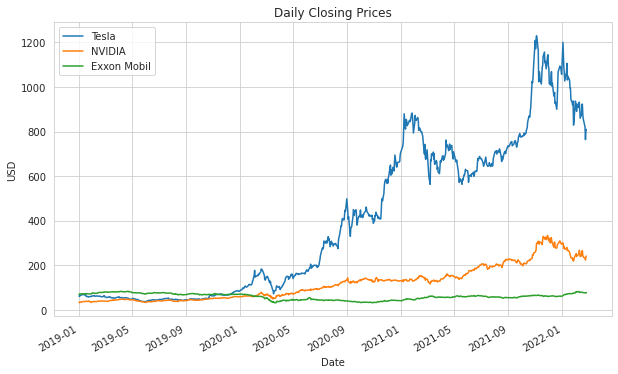

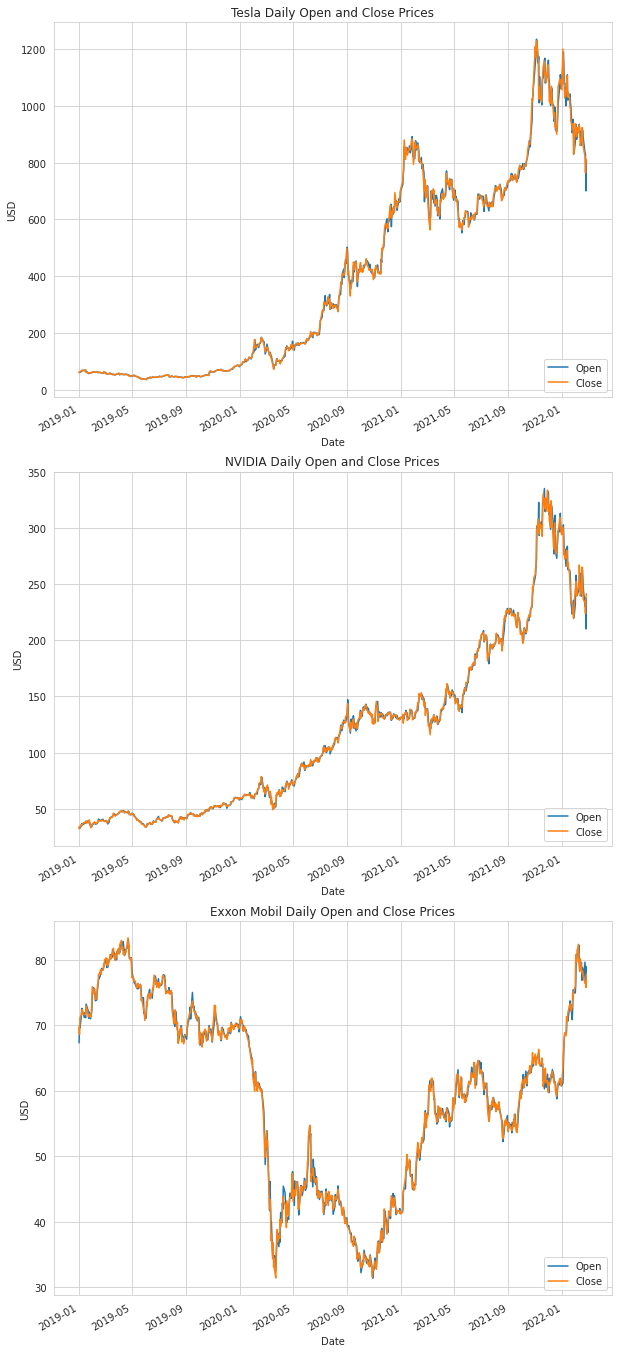

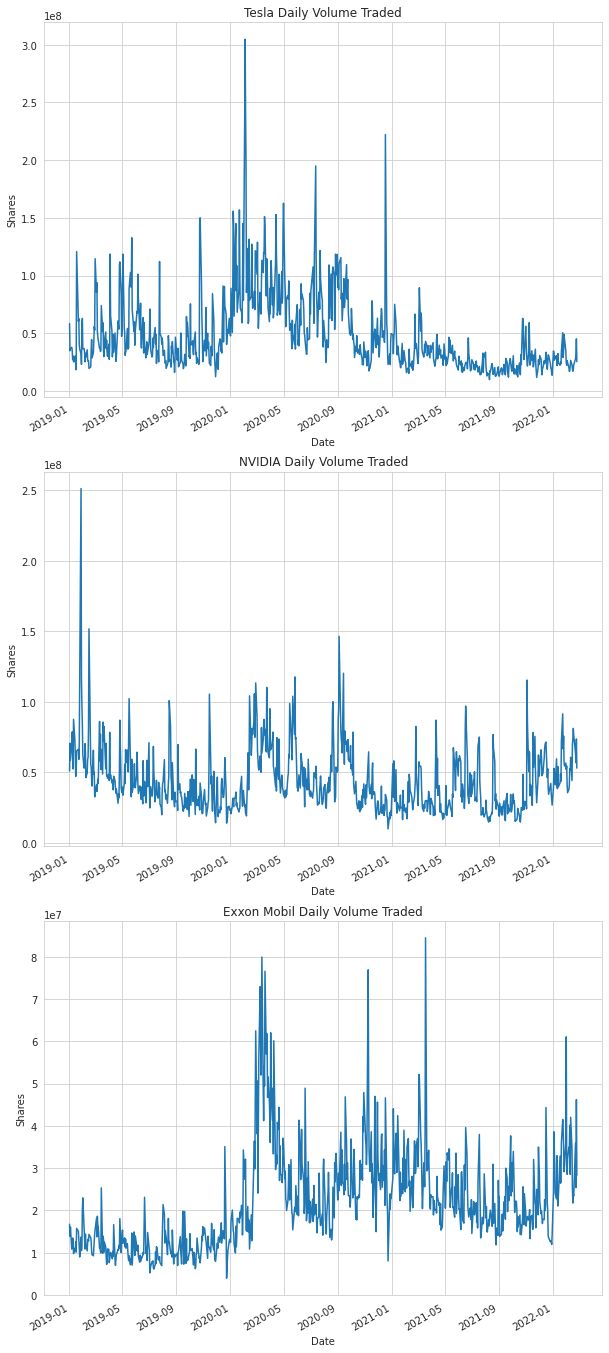

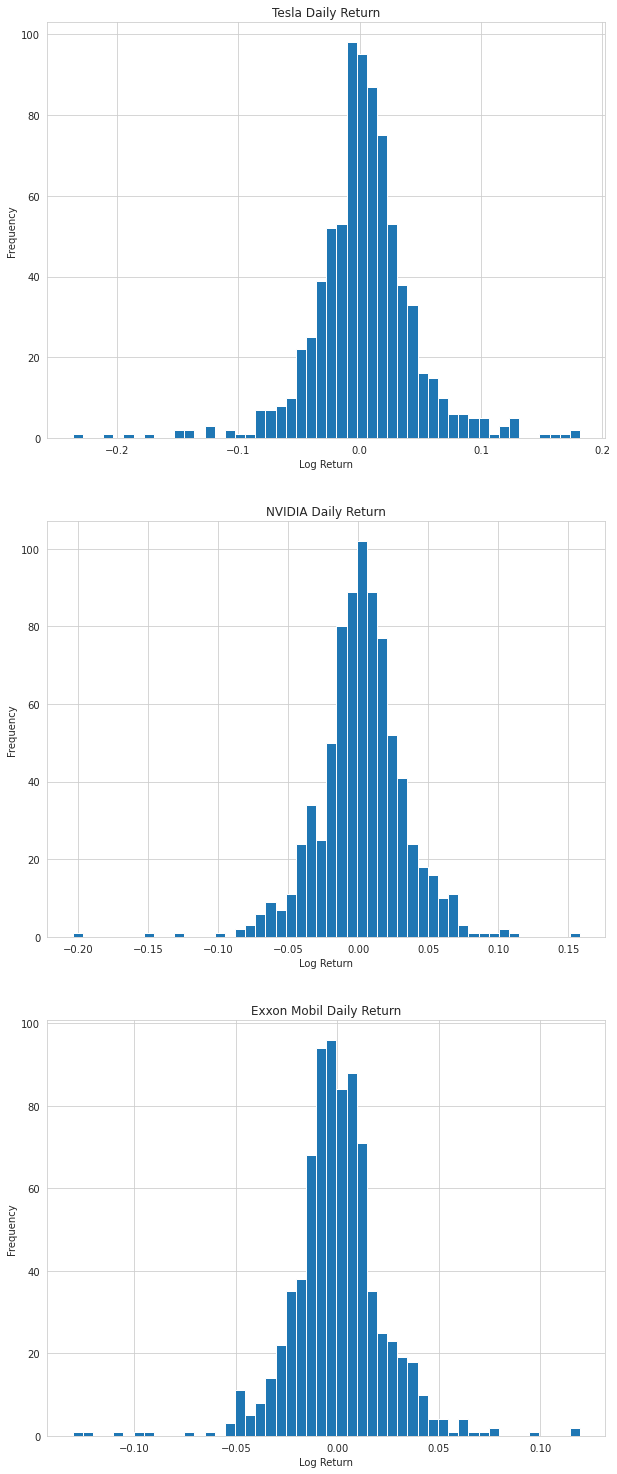

VAR for Tesla
5% quantile  -0.06653962651049658
95% quantile  0.07301154681305047
25% quantile  -0.025376262387034748
75% quantile  0.03184818268958867
VAR for NVIDIA
5% quantile  -0.04860526906430513
95% quantile  0.053540237453345546
25% quantile  -0.01847544229020068
75% quantile  0.02341041067924111
VAR for Exxon Mobil
5% quantile  -0.037681040759660736
95% quantile  0.037959626458253515
25% quantile  -0.015369337797380932
75% quantile  0.01564792349597372


In [31]:
plot_close_price_on_one_plot(tsla, nvda, xom, 'Tesla', 'NVIDIA', 'Exxon Mobil')
plot_compares_open_and_close_price_on_one_plot(tsla, nvda, xom, 'Tesla', 'NVIDIA', 'Exxon Mobil')
plot_volume_traded(tsla, nvda, xom, 'Tesla', 'NVIDIA', 'Exxon Mobil')
plot_Log_Return(tsla, nvda, xom, 'Tesla', 'NVIDIA', 'Exxon Mobil')
Calculating_value_at_risk(tsla, nvda, xom, 'Tesla', 'NVIDIA', 'Exxon Mobil')

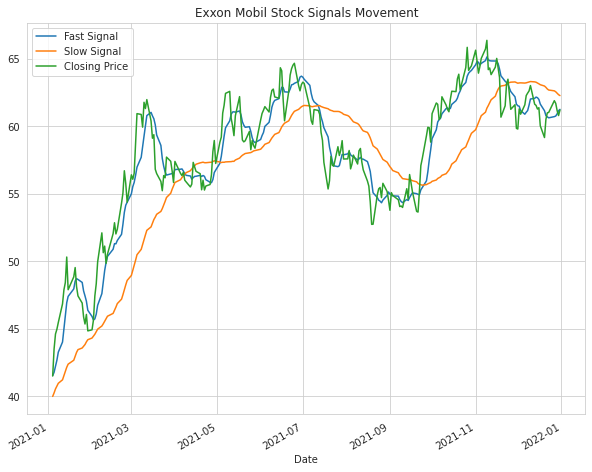

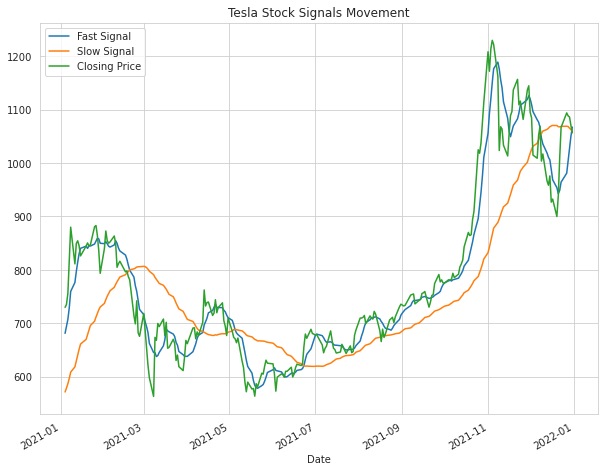

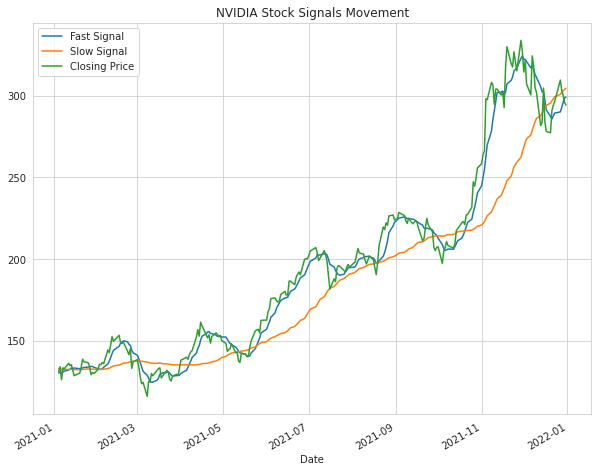

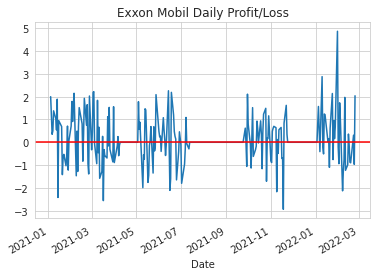

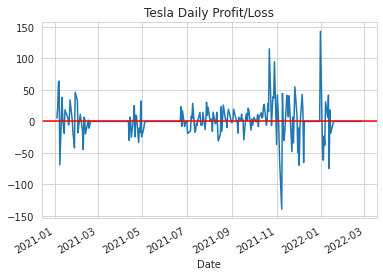

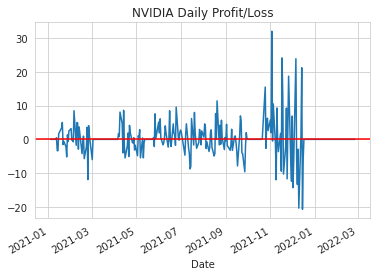

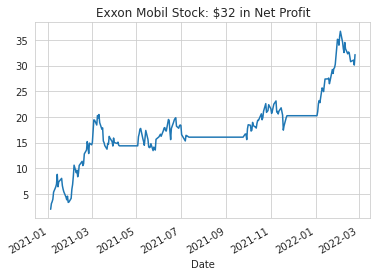

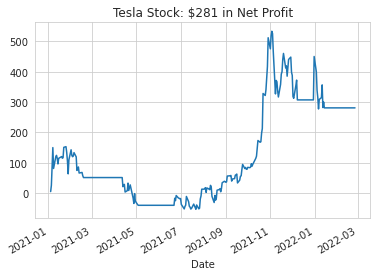

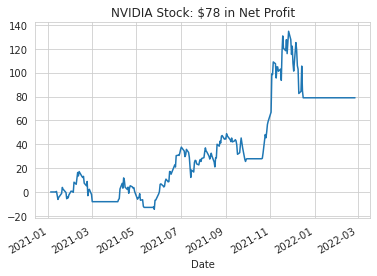

In [32]:
plot_fast_slow_signals(xom, 'Exxon Mobil Stock Signals Movement') 
plot_fast_slow_signals(tsla, 'Tesla Stock Signals Movement') 
plot_fast_slow_signals(nvda, 'NVIDIA Stock Signals Movement') 
plot_profit(xom, 'Exxon Mobil Daily Profit/Loss')
plot_profit(tsla, 'Tesla Daily Profit/Loss')
plot_profit(nvda, 'NVIDIA Daily Profit/Loss')
plot_wealth(xom, 'Exxon Mobil Stock')
plot_wealth(tsla, 'Tesla Stock')
plot_wealth(nvda, 'NVIDIA Stock')

In [38]:
# Data cleaning & merging
oil_price = pd.read_csv('../data/DCOILBRENTEU.csv').rename(columns = {'DATE':'Date'}).assign(Date= lambda oil_price: pd.to_datetime(oil_price['Date'])).assign(DCOILBRENTEU = lambda oil_price: pd.to_numeric(oil_price['DCOILBRENTEU'], errors = 'coerce'))

sp500 =  pd.read_csv('../data/SP500.csv').rename(columns = {'DATE':'Date'}).assign(Date= lambda oil_price: pd.to_datetime(oil_price['Date'])).assign(SP500 = lambda SP500: pd.to_numeric(SP500['SP500'], errors = 'coerce'))
def extract_stock_price(stock):
    '''This functions takes stock price from dataset and import a cleaned dataframe '''
    file_path = os.path.join("../data", stock+'.csv')
    file_folder = pd.read_csv(file_path).assign(Date = lambda stock: pd.to_datetime(stock['Date']))
    return file_folder
tsla = extract_stock_price('TSLA')
nvda = extract_stock_price('NVDA')

def merge_dataset(data1, data2):
    # merge two dataset based on Date
    new_data_frame = pd.merge(data1, data2, on = ['Date'])
    return new_data_frame


oil_sp = merge_dataset(oil_price, sp500)
oil_sp_nvda = merge_dataset(oil_sp, nvda)
oil_sp_nvda_tsla = pd.merge(oil_sp_nvda, tsla, on = ['Date'], suffixes=("_nvda", "_tsla")).set_index(['Date'])
oil_sp_nvda_tsla

,DCOILBRENTEU,SP500,Open_nvda,High_nvda,Low_nvda,Close_nvda,Adj Close_nvda,Volume_nvda,Open_tsla,High_tsla,Low_tsla,Close_tsla,Adj Close_tsla,Volume_tsla
Date,,,,,,,,,,,,,,
2019-01-02,54.06,2510.03,32.660000,34.619999,32.512501,34.055000,33.831314,50875200,61.220001,63.026001,59.759998,62.023998,62.023998,58293000
2019-01-03,53.23,2447.89,33.447498,33.790001,31.922501,31.997499,31.787331,70555200,61.400002,61.880001,59.476002,60.071999,60.071999,34826000
2019-01-04,55.64,2531.94,32.735001,34.432499,32.424999,34.047501,33.823864,58562000,61.200001,63.599998,60.546001,63.537998,63.537998,36970500
2019-01-07,57.10,2549.69,34.625000,36.222500,34.107498,35.849998,35.614521,70916000,64.344002,67.348000,63.549999,66.991997,66.991997,37756000
2019-01-08,56.91,2574.41,36.672501,36.695000,34.224998,34.957500,34.727894,78601600,68.391998,68.802002,65.403999,67.070000,67.070000,35042500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-18,96.18,4348.87,246.679993,249.860001,231.000000,236.419998,236.379730,76125500,886.000000,886.869995,837.609985,856.979980,856.979980,22833900
2022-02-22,98.73,4304.76,230.350006,240.639999,230.000000,233.899994,233.860153,63342200,834.130005,856.729980,801.099976,821.530029,821.530029,27762700
2022-02-23,99.29,4225.50,238.020004,241.550003,223.009995,223.869995,223.831863,56651100,830.429993,835.299988,760.559998,764.039978,764.039978,31752300


In [22]:
# Data Analysis

## In this part you can include your codes to analyse the data,we'll start with (MA, VAT, Trend analysis, ...etc).
## You may also add the visualisation codes to analysis.

In [39]:
# these code will do some basic statsical analysis, before and after pandemic
oil_sp_nvda_tsla.loc['2020-02':'2022-02'].describe()

,DCOILBRENTEU,SP500,Open_nvda,High_nvda,Low_nvda,Close_nvda,Adj Close_nvda,Volume_nvda,Open_tsla,High_tsla,Low_tsla,Close_tsla,Adj Close_tsla,Volume_tsla
count,514.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,5.220000e+02,522.000000,522.000000,522.000000,522.000000,522.000000,5.220000e+02
mean,58.523444,3819.080268,158.110953,161.058362,154.877481,158.090704,157.968776,4.348446e+07,581.853127,595.254057,567.189809,581.875957,581.875957,4.786885e+07
std,19.773545,623.715047,69.163560,70.634270,67.240387,68.869142,68.904937,2.126702e+07,297.182418,303.276969,289.979378,296.748379,296.748379,3.614618e+07
min,9.120000,2237.400000,50.025002,52.485001,45.169998,49.099998,48.997280,9.788400e+06,74.940002,80.972000,70.101997,72.244003,72.244003,9.800600e+06
25%,42.580000,3334.885000,112.611252,113.808749,109.780623,112.424997,112.241015,2.716580e+07,320.399994,330.058998,297.700004,311.631996,311.631996,2.334440e+07
50%,61.130000,3871.015000,137.336251,138.772499,134.477501,136.493752,136.331283,3.782460e+07,637.035004,652.910004,620.505005,642.570007,642.570007,3.440770e+07
75%,73.582500,4384.645000,205.029995,207.297501,202.082504,205.158749,205.089641,5.636700e+07,778.917526,795.402512,768.527497,781.122498,781.122498,6.321078e+07
max,101.660000,4796.560000,335.170013,346.470001,320.359985,333.760010,333.662292,1.463684e+08,1234.410034,1243.489990,1217.000000,1229.910034,1229.910034,3.046940e+08


In [40]:
oil_sp_nvda_tsla.loc['2019-01':'2020-01'].describe()


,DCOILBRENTEU,SP500,Open_nvda,High_nvda,Low_nvda,Close_nvda,Adj Close_nvda,Volume_nvda,Open_tsla,High_tsla,Low_tsla,Close_tsla,Adj Close_tsla,Volume_tsla
count,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,2.730000e+02,273.000000,273.000000,273.000000,273.000000,273.000000,2.730000e+02
mean,64.268828,2941.425348,44.961740,45.603516,44.348562,44.997408,44.803496,4.437294e+07,58.452044,59.511172,57.508315,58.631099,58.631099,4.973016e+07
std,4.349552,174.670059,7.616731,7.591335,7.615774,7.622473,7.636614,2.318681e+07,17.025550,17.504145,16.804551,17.315205,17.315205,2.833308e+07
min,53.230000,2447.890000,32.660000,33.790001,31.922501,31.997499,31.787331,1.388640e+07,36.220001,37.335999,35.397999,35.793999,35.793999,1.232800e+07
25%,61.040000,2832.940000,39.037498,39.514999,38.277500,39.112499,38.895641,3.034880e+07,46.402000,47.200001,45.750000,46.801998,46.801998,3.081300e+07
50%,63.990000,2926.460000,43.305000,44.322498,42.884998,43.500000,43.351063,3.943000e+07,53.750000,54.560001,52.944000,53.556000,53.556000,4.054500e+07
75%,67.050000,3020.970000,49.187500,49.822498,48.825001,49.092499,48.924416,5.116160e+07,64.344002,66.000000,63.223999,65.542000,65.542000,5.900300e+07
max,74.940000,3329.620000,64.375000,64.875000,62.250000,63.215000,63.045044,2.511528e+08,128.000000,130.600006,126.503998,130.113998,130.113998,1.568450e+08


the range for the oil price, SP500 and two stocks prices are big, we can estimate that during the pandemic,both of them exprienced a huge flactulation. Next, We use line charts to more intuitively see their trends before and after the epidemic. To simplify, we focus on close price and compare there trends before and after pandemic

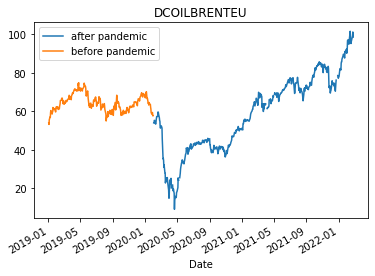

In [41]:
def line_plot_for_otherVar_pandemic(variable):
    oil_sp_nvda_tsla.loc['2020-02' : '2022-02',  variable].plot()
    oil_sp_nvda_tsla.loc['2019-01' : '2020-01',  variable].plot(title = variable).legend(['after pandemic', 'before pandemic'])
    
line_plot_for_otherVar_pandemic('DCOILBRENTEU')


In [ ]:
We can see that crude oil prices fluctuated before the epidemic, and then fell rapidly. After the epidemic, until the end of May 2020, it began to rise continuously 
# macro analysis 

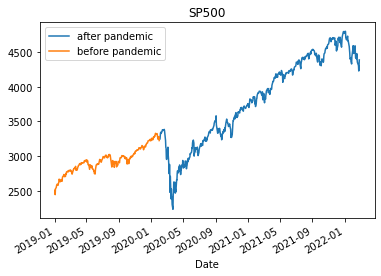

In [42]:
line_plot_for_otherVar_pandemic('SP500')

We can see SP500 rise steadily before the pandemic, but then drop rapidly until May 2020, and then continue to rise. Now we can see that after pandemic, the stock prices of these two high-tech companies have soared. We will conduct in-depth research on the impact of the pandemic on the development of traditional industrial products and high-tech enterprises. 

Because the bases number of each indicator are different, we will analyze the growth rate of each indicator before and after the epidemic, and use a simple econometric model to analyze the impact of oil prices and SP500 on these two stocks.

In [43]:
# we first construct a new dataset, only choose the close price for tsla and nvda
stock_price_anal = oil_sp_nvda_tsla[['Close_nvda', 'Close_tsla', 'DCOILBRENTEU', 'SP500']].dropna()
# mutate variables for calculating growth rates

stock_price_anal['growth_nvda'] =  stock_price_anal['Close_nvda'].pct_change()*100
stock_price_anal['growth_tsla'] =  stock_price_anal['Close_tsla'].pct_change()*100
stock_price_anal['growth_oil_price'] =  stock_price_anal['DCOILBRENTEU'].pct_change()*100
stock_price_anal['growth_sp'] =  stock_price_anal['SP500'].pct_change()*100



then I set two company's stock price's grwoth rates as  dependent variable, SP500 and oil price's growth rates as dependent variable, analysing the effect of change in oil price on these two company's stock prices

In [45]:
def acf_pacf(variable):
    '''plot acf and pacf for stock price'''
    plot_acf(stock_price_anal[[variable]].dropna(), lags = 20)
    plot_pacf(stock_price_anal[[variable]].dropna(), lags = 20)
   

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


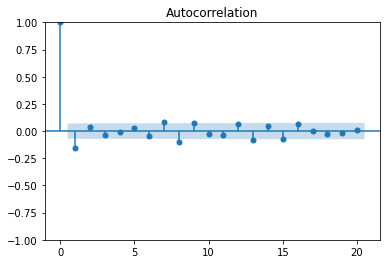

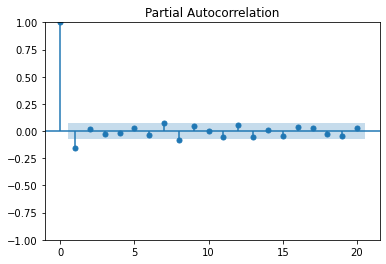

In [46]:
acf_pacf('growth_nvda') 

we can see that the acf and pacf for two stock prices do not provide some reliable information, we use ARIMA model to analyse them and check the result

In [47]:
model = sm.tsa.arima.ARIMA(stock_price_anal[['Close_tsla']], order = (3,0,3))
arima_result = model.fit()
arima_result.summary()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Close_tsla   No. Observations:                  787
Model:                 ARIMA(3, 0, 3)   Log Likelihood               -3507.136
Date:                Mon, 21 Mar 2022   AIC                           7030.272
Time:                        02:21:08   BIC                           7067.618
Sample:                             0   HQIC                          7044.630
                                - 787                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        399.8272    406.312      0.984      0.325    -396.529    1196.184
ar.L1          0.9701      0.283      3.424      0.001       0.415       1.525
ar.L2          0.5939      0.185      3.213      0.001       0.232       0.956
ar.L3         -0.5648      0.251     -2.253      0.024      -1.056      -0.074
ma.L1         -0.0011      0.275     -0.004      0.997      -0.541       0.539
ma.L2         -0.6031      0.253     -2.383      0.017      -1.099      -0.107
ma.L3          0.0876      0.024      3.584      0.000       0.040       0.136
sigma2       431.7637      9.541     45.252      0.000     413.063     450.464
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3193.19
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):             196.40   Skew:                             0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

we can see that tsla stock price is autocorrelated and moving average in its lagged variable

In [48]:
model = sm.tsa.arima.ARIMA(stock_price_anal[['Close_nvda']], order = (3,0,3))
arima_result = model.fit()
arima_result.summary()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Close_nvda   No. Observations:                  787
Model:                 ARIMA(3, 0, 3)   Log Likelihood               -2303.593
Date:                Mon, 21 Mar 2022   AIC                           4623.186
Time:                        02:23:15   BIC                           4660.532
Sample:                             0   HQIC                          4637.544
                                - 787                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        120.6304     84.797      1.423      0.155     -45.569     286.830
ar.L1          1.5013      0.136     11.004      0.000       1.234       1.769
ar.L2         -0.1735      0.262     -0.663      0.508      -0.687       0.340
ar.L3         -0.3281      0.141     -2.323      0.020      -0.605      -0.051
ma.L1         -0.5746      0.133     -4.306      0.000      -0.836      -0.313
ma.L2         -0.3925      0.148     -2.646      0.008      -0.683      -0.102
ma.L3          0.1571      0.025      6.365      0.000       0.109       0.205
sigma2        20.2579      0.516     39.275      0.000      19.247      21.269
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2092.51
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):              41.52   Skew:                             0.60
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

we can see that nvda stock price is autocorrelated and moving average in its lagged variable

Since their first-order lag autoregressive coefficients are close to 1, it is likely that they have unit roots, then I regress the two stock prices for SP500 and oil price, since stock prices might not be affected by oil price and SP500 immediately, I estimate these two variables could have same lag effects on stock price,in this case, I assume the lag effect of oil price and SP 500 about three backward periods to stock prices 

In [50]:
# next, I create some lagged variable for oil price and SP500, since I need test the lasting effect of these macro variables
# I use growth rates for stock prices as dependent variables, and the growth rate of oil price and sp500 as independent variables.
# After the regression, I test the unit root of the residual, try to test the cointegration problems
y = stock_price_anal[['growth_nvda']] 
# create lagged variable for oil price growth rate
stock_price_anal[['lag1_growth_oil_price']] = stock_price_anal[['growth_oil_price']].shift(1)
stock_price_anal[['lag2_growth_oil_price']]  = stock_price_anal[['growth_oil_price']].shift(2)
stock_price_anal[['lag3_growth_oil_price']] = stock_price_anal[['growth_oil_price']].shift(3)
stock_price_anal[['lag4_growth_oil_price']]  = stock_price_anal[['growth_oil_price']].shift(4)
stock_price_anal[['lag5_growth_oil_price']]  = stock_price_anal[['growth_oil_price']].shift(5)


# create lagged variable for SP500 growth rate
stock_price_anal[['lag1_growth_sp']] = stock_price_anal[['growth_sp']].shift(1)
stock_price_anal[['lag2_growth_sp']] = stock_price_anal[['growth_sp']].shift(2)
stock_price_anal[['lag3_growth_sp']] = stock_price_anal[['growth_sp']].shift(3)
stock_price_anal[['lag4_growth_sp']] = stock_price_anal[['growth_sp']].shift(4)
stock_price_anal[['lag5_growth_sp']] = stock_price_anal[['growth_sp']].shift(5)

# create independent variable
X = stock_price_anal[['lag1_growth_oil_price', 'lag2_growth_oil_price', 'lag3_growth_oil_price', 'lag4_growth_oil_price', 
                      'lag5_growth_oil_price', 'lag1_growth_sp', 'lag2_growth_sp', 'lag3_growth_sp', 'lag4_growth_sp', 'lag5_growth_sp']]
nvda_reg = sm.OLS(y, X, missing = 'drop').fit()
nvda_reg_resid = sm.OLS(y, X, missing = 'drop').fit().resid
nvda_reg_resid

Date
2019-01-10    2.002048
2019-01-11    2.213947
2019-01-14    0.537774
2019-01-15   -0.606471
2019-01-16    0.196986
                ...   
2022-02-18   -4.074392
2022-02-22   -1.055257
2022-02-23   -4.838592
2022-02-24    4.868135
2022-02-25    2.596039
Length: 781, dtype: float64

In [ ]:
# then use augmented Dickey-Fuller test to test whether the resid has unit root
adfuller(nvda_reg_resid)

we can see that test-statistic is -27.19, p- value is 0, we can reject null hypothesis that resid has unit root, so resid is not I(1) 

on the other hand, we can conclude that the growth rate of nvda's stock price, oil price, SP500 are cointegrated, 


In [ ]:
nvda_reg.summary()

According to the result, we can see that nvda stock price growth rate has a minimal relationship with lagged oil price and SP 500 growth rate the interesting thing is, the relationship with dependent variables are almost positive, sometimes the coeffcient of lagged variable is negative, but it is not very statistically signiciant. 

In [51]:
# then do the same thing with the growth rate of tsla, check the unit root of residual 
y = stock_price_anal[['growth_tsla']]
X = stock_price_anal[['lag1_growth_oil_price', 'lag2_growth_oil_price', 'lag3_growth_oil_price', 'lag4_growth_oil_price', 
                      'lag5_growth_oil_price', 'lag1_growth_sp', 'lag2_growth_sp', 'lag3_growth_sp', 'lag4_growth_sp', 'lag5_growth_sp']]
tsla_reg = sm.OLS(y, X, missing = 'drop').fit()
tsla_reg_resid = sm.OLS(y, X, missing = 'drop').fit().resid
adfuller(tsla_reg_resid)

(-27.46647485426182,
 0.0,
 0,
 780,
 {'1%': -3.4387614757350087,
  '5%': -2.865252556432172,
  '10%': -2.5687469247205788},
 4353.546024132106)

we can also see that p-value is 0, which means we can reject null hypothesis that resid has unit root, so resid is not I(1),
so the growth rate of tsla's stock price, oil price, SP500 are cointegrated, 

In [52]:
tsla_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            growth_tsla   R-squared (uncentered):                   0.033
Model:                            OLS   Adj. R-squared (uncentered):              0.020
Method:                 Least Squares   F-statistic:                              2.600
Date:                Mon, 21 Mar 2022   Prob (F-statistic):                     0.00416
Time:                        02:36:47   Log-Likelihood:                         -2237.5
No. Observations:                 781   AIC:                                      4495.
Df Residuals:                     771   BIC:                                      4542.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
lag1_growth_oil_price    -0.0054      0.038     -0.142      0.887      -0.081       0.070
lag2_growth_oil_price     0.0834      0.038      2.180      0.030       0.008       0.158
lag3_growth_oil_price     0.1085      0.039      2.793      0.005       0.032       0.185
lag4_growth_oil_price    -0.0671      0.039     -1.723      0.085      -0.143       0.009
lag5_growth_oil_price     0.0371      0.039      0.954      0.341      -0.039       0.113
lag1_growth_sp           -0.0285      0.125     -0.229      0.819      -0.273       0.216
lag2_growth_sp            0.1576      0.128      1.231      0.219      -0.094       0.409
lag3_growth_sp           -0.0503      0.127     -0.395      0.693      -0.300       0.200
lag4_growth_sp            0.2339      0.123      1.905      0.057      -0.007       0.475
lag5_growth_sp           -0.0196      0.120     -0.163      0.871      -0.256       0.216
==============================================================================
Omnibus:                       85.638   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              499.204
Skew:                           0.275   Prob(JB):                    3.97e-109
Kurtosis:                       6.878   Cond. No.                         4.41
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

According to the result, we can see that tsla stock price growth rate has a minimal relationship with lagged oil price and SP 500 growth rate the interesting thing is, the relationship with dependent variables are almost positive, sometimes the coeffcient of lagged variable is negative, but it is not very statistically signiciant. 

And we can find a interesting thing, which is the growth rate of the stock has a noticeable lagged reflection to that of oil prices and SP500, since we can clearly see that the coefficients in second order, third order, fourth order are much higher and statistically siginiciant than first order, we can estimate the growth rate of stock price need some time to make any adjustment.